## CREATE AND CUT THE GRAPH

In [118]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
# !pip install leidenalg==0.7.0

In [229]:
import leidenalg 
import imp
import sys
import types

file, pathname, description = imp.find_module("leidenalg")

print(file)

None


In [120]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy
import skimage.color
import torch.nn.functional as F
from MODULES.graph_clustering import *
import time

## Import files

In [243]:
# LARGE
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v2.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_LARGE.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v3.pt" 

mask_file_hard = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_HARD_EDGES.pt"
mask_file_dot = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_DOT_PRODUCT.pt"
mask_file_l1norm = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_L1_NORM.pt"
mask_file_l2norm = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_L2_NORM.pt"

## Helper function

In [244]:
def all_together_hdbscan(g):
    partition = g.find_partition_hdbscan()
    g.plot_partition(partition, size_threshold=10, figsize=(12,12), density=False, bins=10)

In [245]:
def all_together_watershed(g):
    partition = g.find_partition_watershed()
    g.plot_partition(partition, size_threshold=10, figsize=(12,12), density=False, bins=10)

In [269]:
def all_together_leiden(g, resolution):
    partition = g.find_partition_leiden(resolution=resolution).filter_by_size(min_size=10)
    concordance = partition.concordance_with_partition(other_partition=g.initial_partition)
    
    
    g.plot_partition(partition, min_size=0, figsize=(12,12), density=False, bins=10) #, range=(10,300), windows=[1000,1100,2000,2100])

## Load and plot

In [271]:
tiling = torch.load(mask_file_dot, map_location=torch.device('cpu'))
tiling = tiling.reduce_similarity_radius(new_radius = 2)

g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=False)

torch.Size([1, 100, 100])
torch.Size([3035])
torch.Size([3035])
debug connected components tensor([   0,   82,  618,   41,  282, 1041,  143,  164,  115,  173,  295,   81])


In [272]:
g.graph.summary()

'IGRAPH U-W- 3035 31107 -- \n+ attr: d (v), initial_membership (v), label (v), size (v), weight (e)'

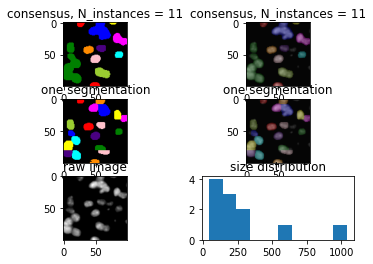

In [273]:
g.plot_cc()

0.79543536901474 2
[193 188 185 184 183 178 176 174 171 168 162 146 138 115 112 101 101  97
  82  81  41]


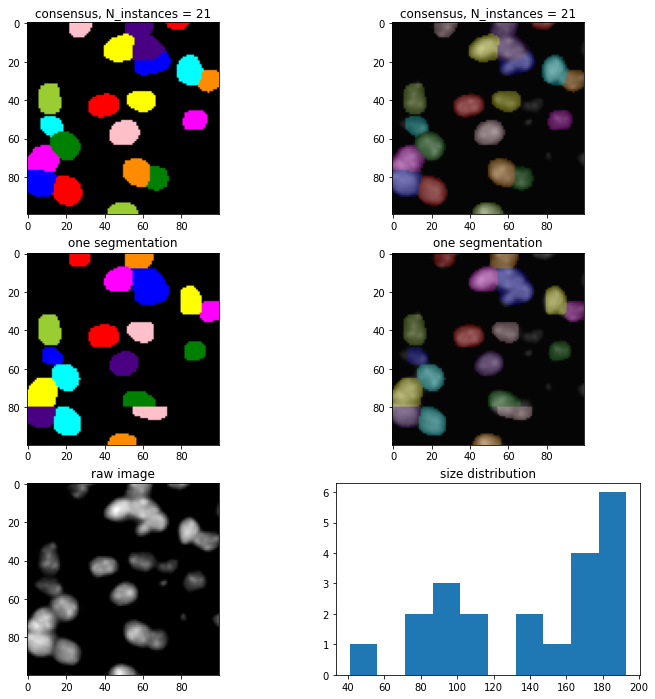

In [374]:
partition = g.find_partition_leiden(resolution=2.0).filter_by_size(min_size=10)
concordance = partition.concordance_with_partition(other_partition=g.initial_partition)
print(concordance.mean_IoU, concordance.delta_n)
g.plot_partition(partition, size_threshold=0, figsize=(12,12), density=False, bins=10) #, range=(10,300), windows=[1000,1100,2000,2100])

In [358]:
concordance

Concordance(joint_distribution=tensor([[0.0000, 0.0086, 0.0214, 0.0125, 0.0076, 0.0046, 0.0086, 0.0013, 0.0056,
         0.0046, 0.0013, 0.0020, 0.0049, 0.0053, 0.0003, 0.0049, 0.0030, 0.0013,
         0.0135],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0521, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0965, 0.0000, 0.0000, 0.0000, 0.0030, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0003, 0.0125, 0.0567,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0540, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0399, 0.0000, 0.0000, 0.0000, 0.0000, 0.00

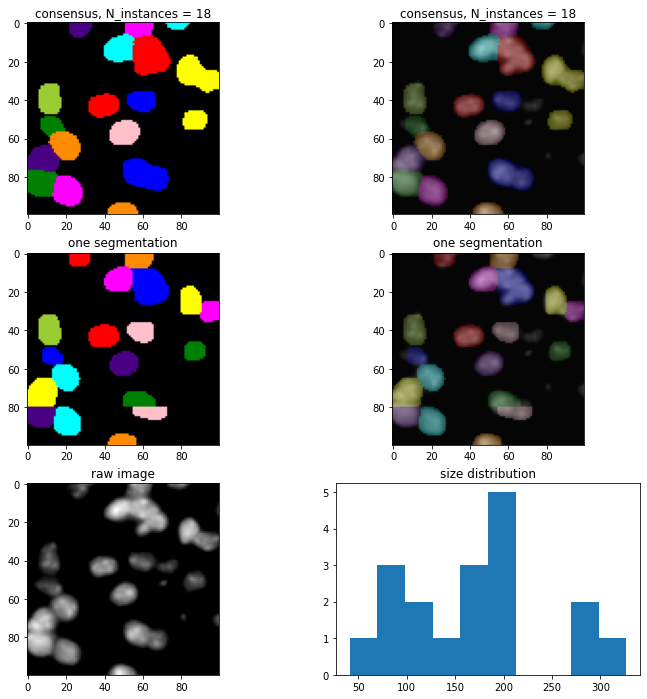

In [356]:
all_together_leiden(g, resolution=0.5)

In [349]:
mi_list, pxy_list, resolution_list, delta_n_list, IoU_list, IoU_reverse_list = [], [], [], [], [], []
for r in numpy.arange(0.1,2.0,0.05):
    partition = g.find_partition_leiden(resolution=r)
    c = GraphSegmentation.concordance_two_partitions(partition,g.initial_partition)
    resolution_list.append(r)
    mi_list.append(c.mutual_information)
    pxy_list.append(c.joint_distribution)
    delta_n_list.append(c.delta_n)
    IoU_list.append(c.mean_IoU)
    IoU_reverse_list.append(c.mean_IoU_reverse)



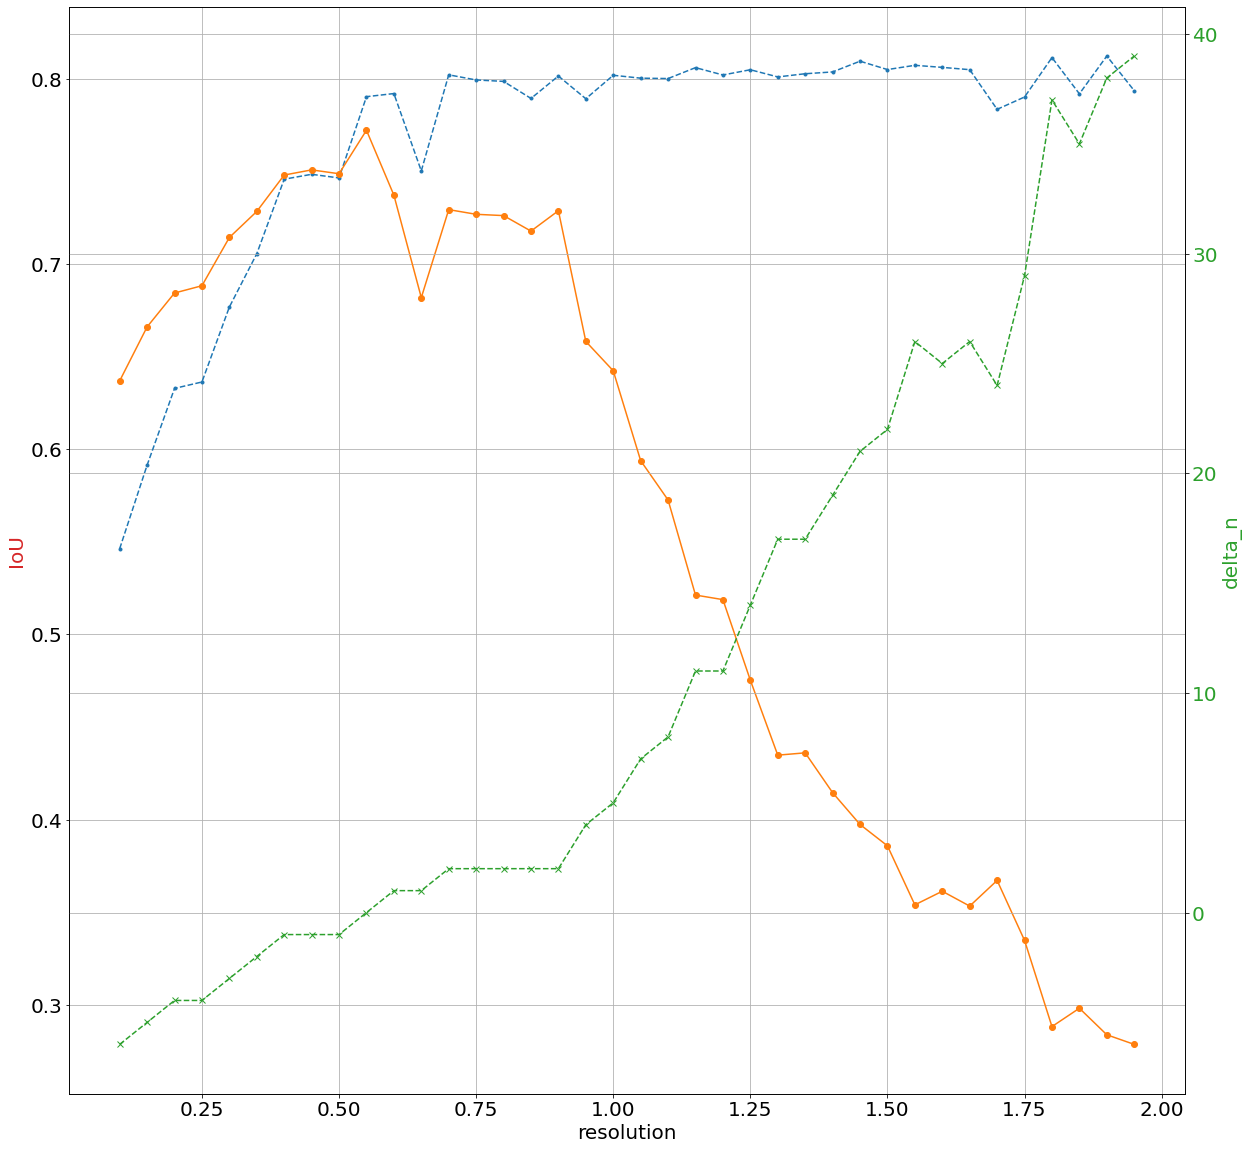

In [353]:
fontsize=20
labelsize=20
figure, ax1a = plt.subplots(figsize=(20,20))

color = 'tab:red'
ax1a.set_xlabel('resolution', fontsize=fontsize)
ax1a.set_ylabel('IoU', fontsize=fontsize, color=color)
ax1a.tick_params(axis='both', which='major', labelsize=labelsize)
ax1a.plot(resolution_list, IoU_list, '.--', label="IoU")
ax1a.plot(resolution_list, IoU_reverse_list, 'o-', label="IoU_reverse")

ax1a.grid()


ax1b = ax1a.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax1b.set_xlabel('resolution', fontsize=fontsize)
ax1b.set_ylabel('delta_n', color=color, fontsize=fontsize)
ax1b.tick_params(axis='both', which='major', labelsize=labelsize)
plt.plot(resolution_list, delta_n_list,'x--',label="delta_n",color=color)
ax1b.tick_params(axis='y', labelcolor=color)
ax1b.grid()


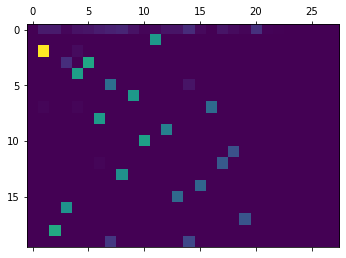

In [354]:
plt.matshow(pxy_list[20])

In [ ]:
plt.plot

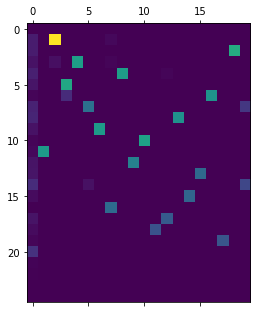

In [284]:
plt.matshow(pxy)

In [178]:
g.graph.es["weight"]

[0.040928009897470474,
 0.7575568556785583,
 0.8683187961578369,
 0.8902979493141174,
 0.8912774324417114,
 0.8912776112556458,
 0.8912776708602905,
 0.891277551651001,
 0.7692912817001343,
 0.7692912817001343,
 0.7669718861579895,
 0.2632819712162018,
 0.4999835789203644,
 0.98581862449646,
 0.9858908653259277,
 0.9858909249305725,
 0.9858909249305725,
 0.9858909249305725,
 0.9858909249305725,
 0.9858909249305725,
 0.8648382425308228,
 0.9883217811584473,
 0.9883217215538025,
 0.9883217215538025,
 0.9883217215538025,
 0.883190393447876,
 0.06281924247741699,
 0.14967602491378784,
 0.6530646681785583,
 0.8127338290214539,
 0.8360443711280823,
 0.8360450863838196,
 0.83604496717453,
 0.83604496717453,
 0.7388710975646973,
 0.7388816475868225,
 0.7323542237281799,
 0.7077128291130066,
 0.13044434785842896,
 0.0366642102599144,
 0.7523810863494873,
 0.8884890675544739,
 0.8912773132324219,
 0.8912776112556458,
 0.8912776112556458,
 0.8912776708602905,
 0.8912776708602905,
 0.7692912817001

In [179]:
#ig.plot(g.graph)

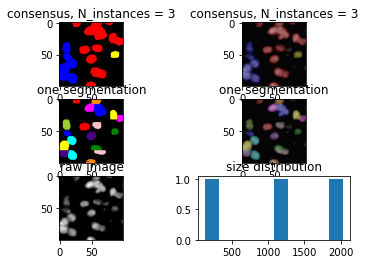

In [180]:
g.plot_cc()

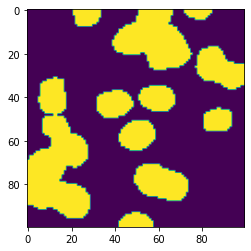

In [102]:
plt.imshow(g.img_to_flood)

13


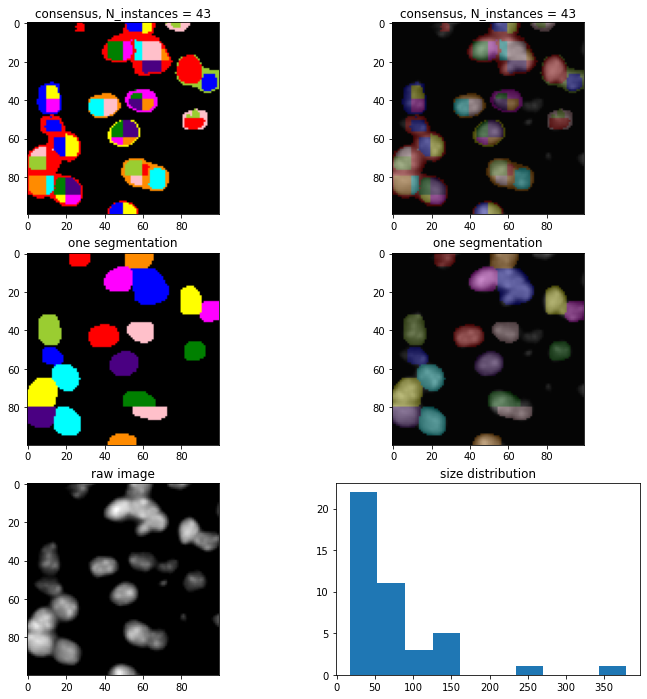

In [105]:
all_together_hdbscan(g)

[autoreload of MODULES.graph_clustering failed: Traceback (most recent call last):
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 

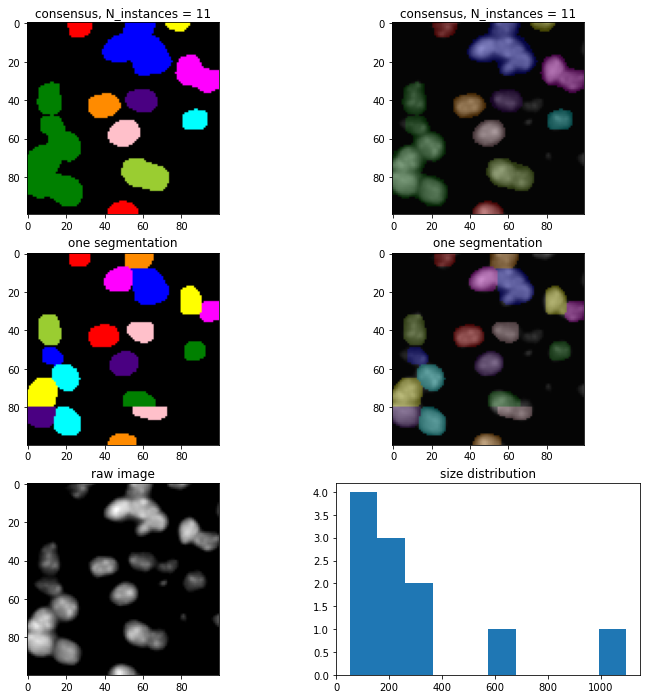

In [21]:
all_together_watershed(g)

1
0
cluster 0 out of 1


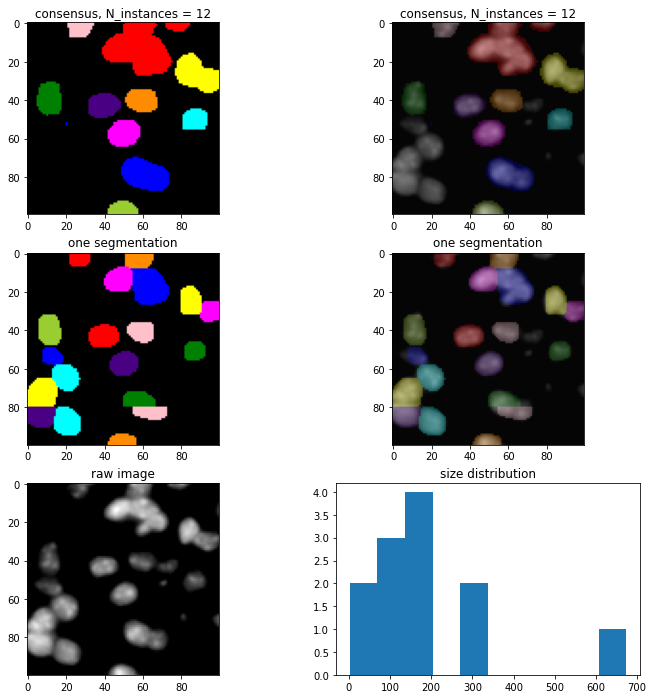

In [557]:
all_together_leiden(g, resolution=0.0001)

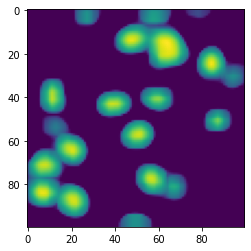

In [362]:
#plt.imshow(g.img_to_flood)

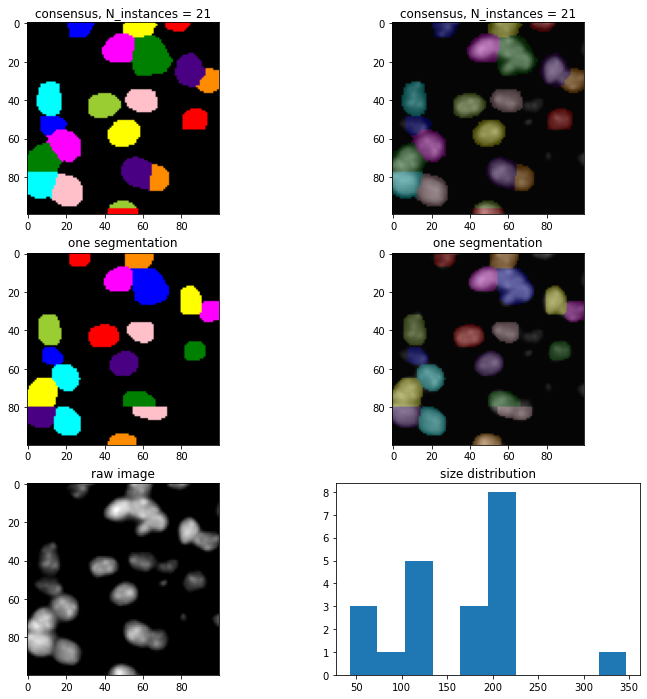

In [361]:
all_together_watershed(g)